In [2]:
!pip install tqdm 
import tqdm
from tqdm import tqdm
tqdm.pandas()

In [3]:
import kagglehub
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import os
import pandas as pd
!pip install joblib
import joblib
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vritika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vritika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vritika/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vritika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

print("Path to dataset files:", path)

Path to dataset files: /Users/vritika/.cache/kagglehub/datasets/shanegerami/ai-vs-human-text/versions/1


In [5]:
list_file=os.listdir(path)
print(f"name of file in the folder :  {list_file}")

name of file in the folder :  ['AI_Human.csv']


In [6]:
# Load the data
df = pd.read_csv(f"{path}/{list_file[0]}", nrows=90000)

# Separate the two classes
df_0 = df[df['generated'] == 0.0]
df_1 = df[df['generated'] == 1.0]

# Sample 16,000 rows from each class (with or without replacement depending on available data)
df_0_sampled = df_0.sample(n=25000, random_state=42)
df_1_sampled = df_1.sample(n=16000, random_state=42)

# Combine to form the balanced dataset
df = pd.concat([df_0_sampled, df_1_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
df.head()

,text,generated
0,This landform on mars does look like a alien f...,0.0
1,"Dear TEACHER_NAME, no I do not think all stude...",0.0
2,Students nowadays have more and more options i...,0.0
3,"Dear Principle,\n\nStudents should be allowed ...",0.0
4,So why do ask other people for their own opini...,0.0


In [8]:
df.shape

(41000, 2)

In [9]:
df['generated'].unique()

array([0., 1.])

Dataset consists of 487235 rows and 2 columns namely text and generated.

The column 'text' is the corpus and 'generated' has two values 0 and 1.

Generated by AI : 1 and Human Text: 0

In [10]:
#Preprocessing
#1. Lowercasing

df['text'] = df['text'].str.lower()

In [11]:
df['generated'] = df['generated'].astype(int)

In [13]:
#2. Removing Punctuation
df['text'] = df['text'].str.translate(str.maketrans('', '', string.punctuation))

In [14]:
#3. Removing Extra Spaces
df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

In [15]:
df['tokens'] = df['text'].apply(word_tokenize)

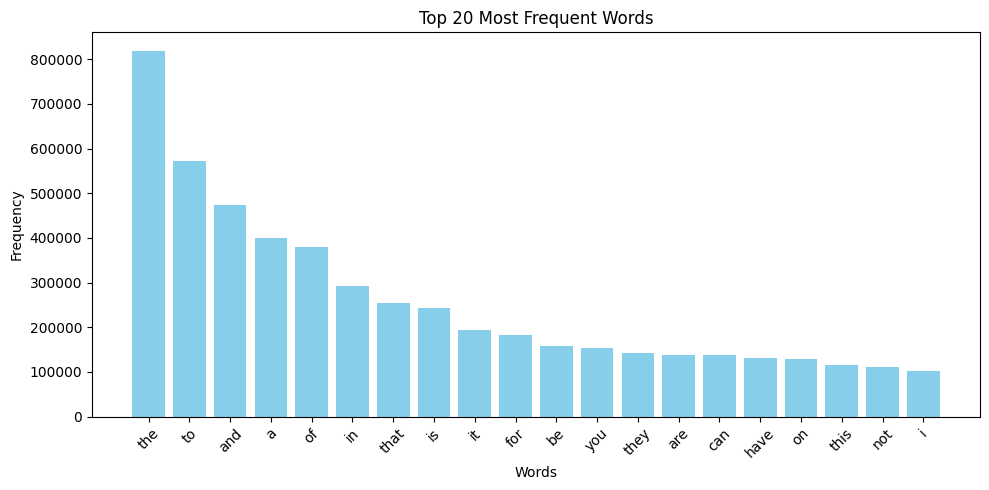

In [16]:
all_words = [word for tokens in df['tokens'] for word in tokens]

# Step 2: Count word frequencies
word_freq = Counter(all_words)

# Step 3: Get top 20 most common words
common_words = word_freq.most_common(20)

# Step 4: Separate words and counts
words, counts = zip(*common_words)

# Step 5: Plot
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [17]:
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [18]:
#Stemming
stemmer = PorterStemmer()
df['stemmed_tokens'] = df['tokens'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

In [21]:
#vectorization
df['clean_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

In [22]:
df['clean_text'].head()

0    landform mar look like alien face another regu...
1    dear teachername think student required commun...
2    student nowadays option classroom ever past wh...
3    dear principle student allowed use phone free ...
4    ask people opinion help u make better choice w...
Name: clean_text, dtype: object

In [53]:
vectorizer = TfidfVectorizer(max_features=100)

In [54]:
X = vectorizer.fit_transform(df['clean_text'])
y = df['generated']

In [55]:
# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
#1 . L O G I S T I C  R E G R E S S I O N
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_preds))

Logistic Regression Accuracy: 0.9264634146341464


In [57]:
#2. N A I V E  B A Y E S
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))

Naive Bayes Accuracy: 0.8628048780487805


In [58]:
#3. S V M
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

SVM Accuracy: 0.9248780487804878


In [59]:
print("\n=== Classification Report (Logistic) ===")
print(classification_report(y_test, log_preds))

print("\n=== Classification Report (Naive Bayes) ===")
print(classification_report(y_test, nb_preds))

print("\n=== Classification Report (SVM) ===")
print(classification_report(y_test, svm_preds))



=== Classification Report (Logistic) ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5049
           1       0.92      0.89      0.90      3151

    accuracy                           0.93      8200
   macro avg       0.92      0.92      0.92      8200
weighted avg       0.93      0.93      0.93      8200


=== Classification Report (Naive Bayes) ===
              precision    recall  f1-score   support

           0       0.84      0.95      0.90      5049
           1       0.91      0.72      0.80      3151

    accuracy                           0.86      8200
   macro avg       0.88      0.84      0.85      8200
weighted avg       0.87      0.86      0.86      8200


=== Classification Report (SVM) ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5049
           1       0.91      0.89      0.90      3151

    accuracy                           0.92      8200
   m

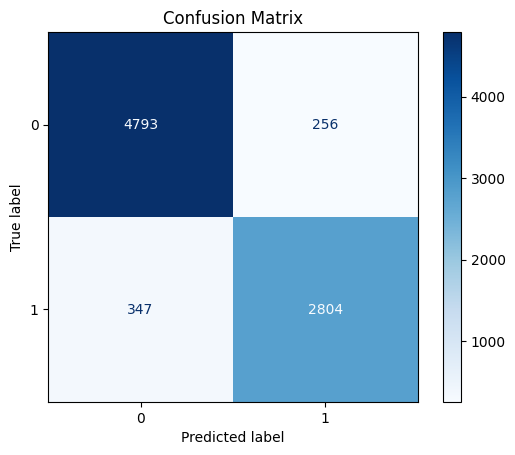

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# y_test: actual labels
# y_pred: predicted labels (from your model)

cm1 = confusion_matrix(y_test, log_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['0', '1'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [61]:
joblib.dump(log_model, 'logistic_model.pkl')
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [62]:
# from google.colab import files
# files.download('logistic_model.pkl')
# files.download('naive_bayes_model.pkl')
# files.download('svm_model.pkl')
# files.download('vectorizer.pkl')

In [66]:
vectorizer = joblib.load('vectorizer.pkl')
model = joblib.load('logistic_model.pkl')

def predict_text():
    user_input = input("Enter a sentence to check if it's AI-generated or Human-written:\n")

    # Preprocessing and vectorizing
    transformed_input = vectorizer.transform([user_input])

    # Predict
    prediction = model.predict(transformed_input)

    # Output
    if prediction[0] == 1:
        print(" This text is likely AI-generated.")
    else:
        print("This text is likely Human-written.")


# Run it
predict_text()

Enter a sentence to check if it's AI-generated or Human-written:
  life on another planet like mars even if there was a alien civilazation why isnt there any more of these or different formation and buildings on mars that is why it is just a regular landform on mars well this mesa is fooling people because it does look like a face but it is just another mesa the shadow are just placed coincedentily the landform is pretty big so it coudlnt be built fast enough for it to go unnoticed plus nasa isnt hiding anything why would they need to that is one of the reasons why i think it is a coincedent even though nasa seems like they want to cover it they really dont want to because it will be the biggest find ever in space age history we send probes and rovers for research and to fin


This text is likely Human-written.


In [70]:
predict_text()

Enter a sentence to check if it's AI-generated or Human-written:
 r resulting in healthier citizens and a more sustainable environment 2 reduced greenhouse gas emissions cars and other motor vehicles contribute significantly to greenhouse gas emissions which are major factors in global warming eliminating cars can significantly decrease these emissions and mitigate their harmful effects on the environment 3 better mobility carfree cities prioritize walking bicycling and public transportation by encouraging these alternative modes of transportation they promote physical activity reduce traffic congestion and improve overall urban mobility 4 enhanced livability carfree cities often feature wider sidewalks pedestrian zones and bicycle paths making them more pleasant places to live and work additionally the reduction in noise pollution from fewer cars contributes to a more serene atmosphere fostering stronger community connections and overall quality of life 5 economic benefits by reducing

 This text is likely AI-generated.
